In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from os.path import join

from models.base_line import BasicModel
from training.trainer_base import Trainer
from data.transforms import ResizeTransform
from utils.cross_validation import MyKFoldCV
from utils.dataset_handling import DatasetHandler
from utils.metrics import compute_confusion_matrices, compute_accuracy, compute_f1score
from utils.visulisation import visualize_confusion_matrices

torch.manual_seed(42)


in_size = 128
out_size = 2

project_path = "C:/Users/Admin/projects/Eye_Tracking/"
assert(os.path.exists(project_path))

In [2]:
data_type = 'heatmap'       # scanpath or heatmap
scanpath_type = None        # a, b or c
model_type = 'def_cnn'      # def_cnn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if model_type == 'def_cnn':
    model = BasicModel(in_size, out_size)
print('using device: ' + device.__str__())
# Create a dataset from image folder
root = join(project_path, 'data/datasets/{}s/'.format(data_type))
if data_type == 'scanpath':
    root = join(root, '{}/'.format(scanpath_type))

transform = ResizeTransform(in_size, in_size)

dataset = DatasetHandler(root, transform)

outer_kfolds = 8
inner_kfolds = 7
batch_size = 32

outer_cv = MyKFoldCV(dataset, outer_kfolds, create_train_loaders=False, batch_size=batch_size)
inner_cv = MyKFoldCV(dataset, inner_kfolds, ignore=outer_cv.get_test_participants(), batch_size=batch_size)

learning_rate = 0.02

# Define the loss function and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Define trainer 
save_path = join(project_path, 'saved_models/{}s_{}'.format(data_type, model_type))

trainer = Trainer(model, save_path, loss, optimizer=optimizer)

using device: cuda


In [3]:
# training
for i in range(inner_cv.get_k()):
    print(f'fold: {i+1}')
    num_epochs = 20
    train_loader = inner_cv.get_train_loader()
    test_loader = inner_cv.get_test_loader()
    print('validating on: ', inner_cv.get_test_participants())
    trainer.set_train_loader(train_loader)
    trainer.set_val_loader(test_loader)
    for _ in range(num_epochs):
        trainer.run_epoch()
    inner_cv.next_split()

fold: 1
validating on:  ['31', '4', '29', '5']
11.03 15:12:12 --- Epoch [1], Loss: 1.2640, Val acc: 76.19
11.03 15:12:13 --- Epoch [2], Loss: 0.5953, Val acc: 76.19
11.03 15:12:14 --- Epoch [3], Loss: 0.6075, Val acc: 76.19
11.03 15:12:14 --- Epoch [4], Loss: 0.6823, Val acc: 76.19
11.03 15:12:15 --- Epoch [5], Loss: 0.6628, Val acc: 76.19
11.03 15:12:16 --- Epoch [6], Loss: 0.6630, Val acc: 76.19
11.03 15:12:17 --- Epoch [7], Loss: 0.6439, Val acc: 76.19
11.03 15:12:18 --- Epoch [8], Loss: 0.6314, Val acc: 76.19
11.03 15:12:19 --- Epoch [9], Loss: 0.6036, Val acc: 76.19
11.03 15:12:20 --- Epoch [10], Loss: 0.6306, Val acc: 76.19
11.03 15:12:21 --- Epoch [11], Loss: 0.6106, Val acc: 76.19
11.03 15:12:22 --- Epoch [12], Loss: 0.5844, Val acc: 76.19
11.03 15:12:23 --- Epoch [13], Loss: 0.5615, Val acc: 76.19
11.03 15:12:24 --- Epoch [14], Loss: 0.5788, Val acc: 76.19
11.03 15:12:25 --- Epoch [15], Loss: 0.5913, Val acc: 76.19
11.03 15:12:26 --- Epoch [16], Loss: 0.5687, Val acc: 76.19
11

In [4]:
trainer.save_best_model()
print('testing on: ', outer_cv.get_test_participants())
trainer.test(outer_cv.get_test_loader())
# ['17', '18', '8', '2']

Saving best model to   C:/Users/Admin/projects/Eye_Tracking/saved_models/heatmaps_def_cnn\best_model.pkl
testing on:  ['17', '18', '8', '2']


0.9545454545454546

In [13]:
test_model = BasicModel(in_size, out_size)
test_model.load_state_dict(torch.load(join(project_path, 'saved_models/heatmaps_def_cnn/best_model.pkl')))
test_pp = ['17', '18', '8', '2']

In [6]:
test_trainer = Trainer(test_model, save_path, loss, optimizer=optimizer)


In [11]:
print(compute_accuracy(test_model, dataset, test_pp))
print(compute_f1score(test_model, dataset, test_pp))

0.9545454545454546
0.953168044077135


In [11]:
outer_cv.get_test_participants()

['17', '18', '8', '2']

In [14]:
cfs = compute_confusion_matrices(test_model, dataset, test_pp)

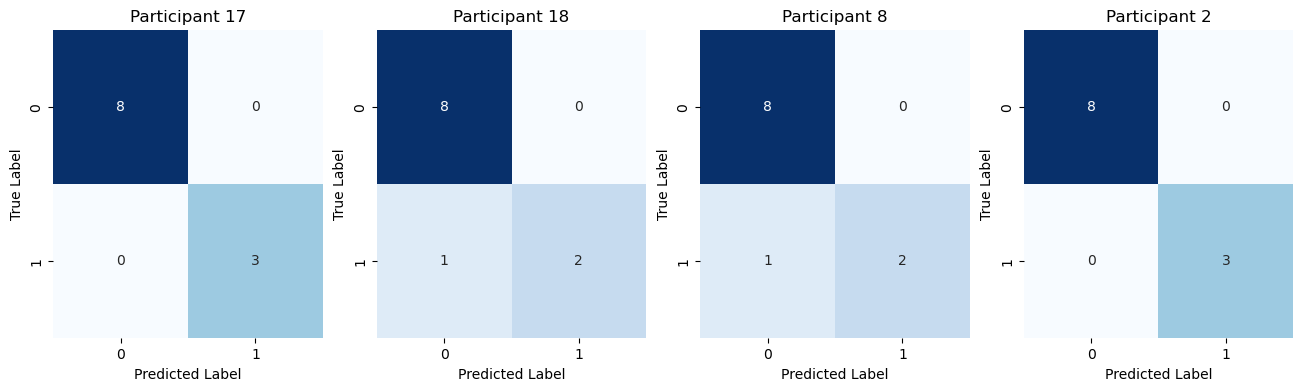

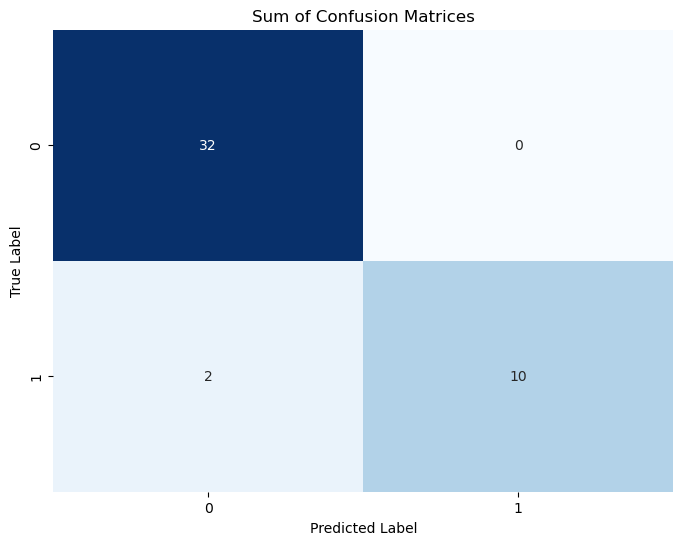

In [15]:
visualize_confusion_matrices(cfs)